### CIFAR 10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [3]:
# Applying transforms to an image Some are mandatory like conversion to a tensor
# and normalize the image. Others are optional and used for data augmentation 
# (like random crop, random jitter etc.)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5 , 0.5, 0.5), (0.5, 0.5, 0.5))])

torch.utils.data.Dataset is an abstract class inherited by all the in-built datasets of pytorch. This class represents a dataset 
by using the __len__() and __iter__() function allows clients to iterate through datasets. Custome implementations should inherit this class and provide standard interface to it's clients.

In [4]:
trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform)

In [5]:
len(trainset.train_data)

50000

9


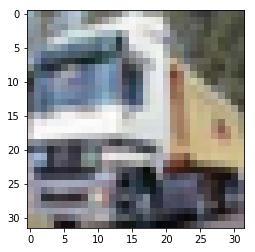

In [7]:
plt.imshow(trainset.train_data[1])

In [8]:
print(trainset.train_labels[1])

9


In [9]:
# happens to be truck class

torch.utils.data.DataLoader can load multiple samples parallely. It provides aniterator to iterate over batches, with the 
batchsize specified. It helps in

- Batching the data
- Shuffling the data
- Loading the data in parallel using multiprocessing workers.

In [10]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True, num_workers=2)

### training loop

In [13]:
for i,data in enumerate(trainloader):
    data, labels = data
    print("iteration",i)
    print("")
    print("type of data:",type(data))
    print("size of data:",data.size())
    print("")
    print("type of labels:",type(labels))
    print("size of labels:",labels.size())  
    
    # model is trained here
    break

iteration 0

type of data: <class 'torch.FloatTensor'>
size of data: torch.Size([10, 3, 32, 32])

type of labels: <class 'torch.LongTensor'>
size of labels: torch.Size([10])


### Custom Datasets

For reading custom datasets we need to create our own custom Dataset class which inherits from torch.utils.data.Dataset

Then we use torch.utils.DataLoader to iterate through the data as well as for shuffling

We need to override the len and iter function to provide our own functionality in the dataset class

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [5]:
landmarks_frame = pd.read_csv('faces/face_landmarks.csv')
landmarks_frame.head()

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,...,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,...,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,...,293,507,331,511,294,516,279,518,265,516


In [6]:
n = 65
img_name = landmarks_frame.iloc[n,0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()

In [12]:
landmarks = landmarks.astype('float').reshape(-1,2)
landmarks.shape

(68, 2)

In [13]:
landmarks[:4]

array([[32., 65.],
       [33., 76.],
       [34., 86.],
       [34., 97.]])

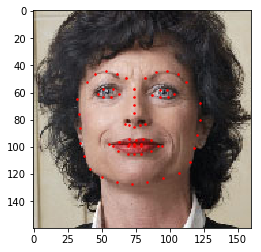

In [19]:
def show_landmarks(image, landmarks):
    "Show image with landmarks"
    plt.imshow(image)
    plt.scatter(landmarks[:,0], landmarks[:,1], s=10, marker='.', c='r')
    plt.pause(0.001)

plt.figure()
show_landmarks(io.imread(os.path.join('faces/',img_name)), landmarks)
plt.show()

### Writing Custom Dataset Class

We need to override following methods:
- \_\_len\_\_
- \_\_getitem\_\_ to support indexing such that dataset[i] can return ith sample

In [24]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks Dataset"""
    
    def __init__(self, csv_file, root_dir, transform = None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx,0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1,2)
        sample = {'image': image, 'landmarks': landmarks}
        if self.transform:
            sample = self.transform(sample)
        return sample

0 (324, 215, 3) (68, 2)


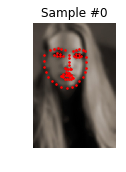

1 (500, 333, 3) (68, 2)


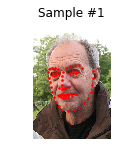

2 (250, 258, 3) (68, 2)


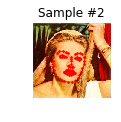

3 (434, 290, 3) (68, 2)


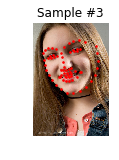

In [26]:
face_dataset = FaceLandmarksDataset(csv_file="faces/face_landmarks.csv", root_dir="faces/")
fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    
    print(i, sample['image'].shape, sample['landmarks'].shape)
    
    ax = plt.subplot(1, 4, (i + 1))
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)
    
    if i == 3:
        plt.show()
        break

#### Transform the images for Neural Net processing and data augmentation

- Rescale: to scale the image
- RandomCrop: crop the image randomly. This is data augmentation
- ToTensor: Convert numpy images to torch images

Making callable transforms so that params need not to be passed again and again.

In [30]:
class Rescale(object):
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h>w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size*w/h
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)
        
        img = transform.resize(image, (new_h, new_w))
        landmarks = landmarks * [new_w / w, new_h / h]
        return {'image': img, 'landmarks': landmarks}

In [32]:
class RandomCrop(object):
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
            
    def __call__(self, sample):
        
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}        

In [34]:
class ToTensor(object):
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        image = image.transpose((2,0,1))
        return {'image': torch.from_numpy(image), 
                'landmarks': torch.from_numpy(landmarks)}

Compose and apply transforms

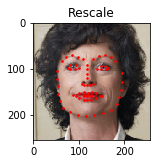

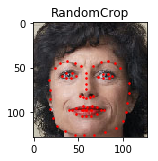

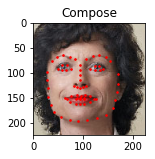

In [35]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256), RandomCrop(224)])
# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

In [36]:
transformed_dataset = FaceLandmarksDataset(csv_file="faces/face_landmarks.csv", root_dir="faces/", transform = transforms.Compose([Rescale(256), RandomCrop(224), ToTensor()]))

In [37]:
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


Still missing:
- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers.

we will use torch.utils.data.DataLoader that provides all these features.

In [41]:
data_loader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=4)

In [42]:
#Helper function to show a batch

def show_landmarks_batch(sample_batched):
    images_batch, landmarks_batch = sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1,2,0)))
    
    for i in range(batch_size):
        plt.scatter(landmarks_batch[i,:,0].numpy() + i * im_size, landmarks_batch[i, :, 1].numpy(), s=10, marker='.', c='r')
    plt.title('Batch from dataloader')

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


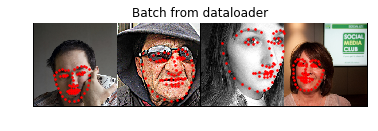

In [43]:
for i_batch, sample_batched in enumerate(data_loader):
    print(i_batch, sample_batched['image'].size(), sample_batched['landmarks'].size())
    
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break